# Classification

## MNIST

In [1]:
# Load MNIST dataset

from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]

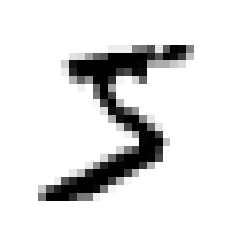

In [3]:
# Look at one example
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = np.array(X.iloc[0])
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [4]:
y[0]

'5'

In [5]:
y = y.astype(np.uint8)

In [6]:
# Create train and test sets

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

In [7]:
# Let's simplify the problem for now and only try to identify one digit
# This detector will be an example of a binary classifier
# Let's create the target vectors for this classification task

y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [8]:
# Let's create a Stochastic Gradient Descent classifier

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

/usr/local/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [10]:
# Implementing Cross-Validation

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [11]:
# Let's evaluate the SGDClassifier using K-fold cross-validation

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [12]:
# How does this accuracy compares with a dumb classifier 
# that just classifies every single image in the "not-5" class ?

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

# Above 90 % accuracy (ratio of correct predictions) on all cross-validation folds ?
# This is simply because only about 10 % of the images are 5s, so if you always guess that an image is not 5
# You will be right about 90 % of the time
# Accuracy is generally not the preferred performance measure for classifiers, especially when dealing with skewed datasets

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [13]:
# Let's make predictions to compute the confusion matrix

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
# Compute confusion matrix

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

### Precision and Recall

In [15]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(y_train_5, y_train_pred))
print("Recall:", recall_score(y_train_5, y_train_pred))

Precision: 0.8370879772350012
Recall: 0.6511713705958311


In [16]:
# Combine precision and recall and get F1-score

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision / Recall Tradeoff

In [17]:
# Let's return a score for each instance instead of a prediction
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

# Let's set an artificial classification threshold to 0
threshold = 0
print("Threshold:", threshold)
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

# Let's now raise the threshold to 8000
threshold = 8000
print("Threshold:", threshold)
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
Threshold: 0
[ True]
Threshold: 8000
[False]


/usr/local/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [18]:
# Deciding which threshold to use
# Get scores of all instances in the training set

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [19]:
# Compute precision and recall for all possible thresholds

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

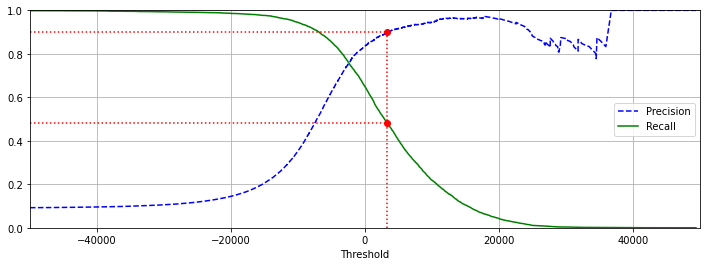

In [20]:
# Plot precision and recall as functions of the threshold

import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right")
    plt.xlabel("Threshold")
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    
recall_90_precision = recalls[np.argmax(precisions>=0.9)]
threshold_90_precision = thresholds[np.argmax(precisions>=0.9)]

plt.figure(figsize=(12,4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [.9, .9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

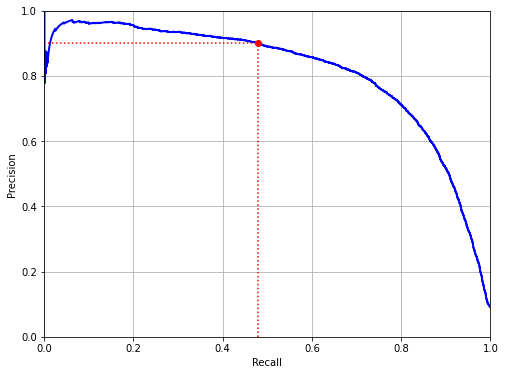

In [21]:
# Plot precision as a function of the recall

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plt.figure(figsize=(8,6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., .9], "r:")
plt.plot([0.0, recall_90_precision], [.9, .9], "r:")
plt.plot([recall_90_precision], [.9], "ro")
plt.show()

In [22]:
# Let's suppose we decide to aim for 90 % precision.
# Let's search for the lowest threshold that gives at least 90% precision

threshold_90_precision = thresholds[np.argmax(precisions>=0.9)]

In [23]:
# To make predictions (on the training set for now), instead of calling the classifier's predict() method, let's use this threshold

y_train_pred_90 = (y_scores >= threshold_90_precision)

In [24]:
# Let's check these prediction's precision and recall

print("Precision with 90% precision threshold: {:.2f}".format(precision_score(y_train_5, y_train_pred_90)))
print("Recall with 90% precision threshold: {:.2f}".format(recall_score(y_train_5, y_train_pred_90)))

Precision with 90% precision threshold: 0.90
Recall with 90% precision threshold: 0.48


### The ROC Curve

In [25]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [26]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--") # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)

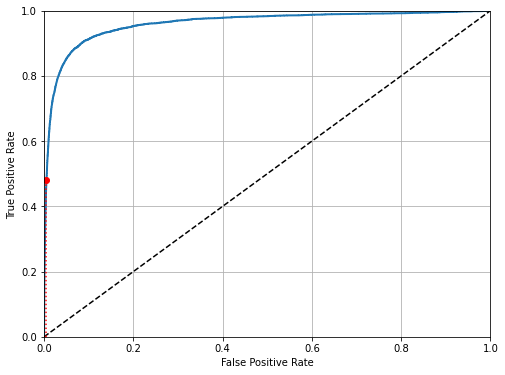

In [27]:
plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()

In [28]:
# One way to compare classifiers is to measure the area under the curve (AUC)
# A perfect classifier will have an ROC AUC=1, whereas a purely random classifier will have an ROC AUC=0.5

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

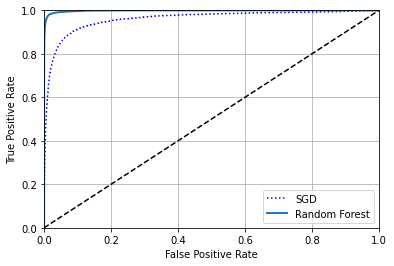

In [29]:
# Let's train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

# To plot an ROC curve, you need scores, not probabilities. A simple solution is to use the positive class probability as the score
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

# Plot ROC curve
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="Random Forest")
plt.legend(loc="lower right")
plt.show()

In [30]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification

In [31]:
# Scikit-Learn detects when you try to use a binary classification algorithm for a multi-class classification task
# and it automatically runs One-vs-All (except for SVM classifiers for which it uses One-vs-One)
# Let's try this with the SGDClassifier

sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])

/usr/local/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

In [32]:
# Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image
# and selected the class with the highest score
# To see that this is indeed the case, you can call the decision_function() method
# It now returns 10 scores, one per class

some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

/usr/local/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [33]:
# The highest score is the one corresponding to class 3

sgd_clf.classes_[np.argmax(some_digit_scores)]

3

In [34]:
# Forcing Scikit-Learn to use One-vs-One or One-vs-All

from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

/usr/local/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but OneVsOneClassifier was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [35]:
# Training a Random Forest Classifier
forest_clf.fit(X_train, y_train)
print(forest_clf.predict([some_digit]))
# This time Scikit-Learn did not have to run One-vs-All nor One-vs-One because Random Forest Classifiers can
# directly classify images into multiple classes
# You can get the list of probabilities that the classifier assigned to each instance for each class
print(forest_clf.predict_proba([some_digit]))

[5]
[[0.   0.   0.01 0.08 0.   0.9  0.   0.   0.   0.01]]


/usr/local/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [36]:
# Let's evaluate the SGDClassifier accuracy using cross-validation

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [37]:
# What would happen if inputs were scaled ?

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [38]:
# Analyse the type of errors a model makes
# Let's say SGDClassifier is our candidate

In [39]:
# Confusion matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

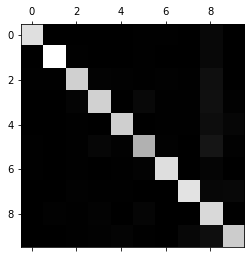

In [40]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

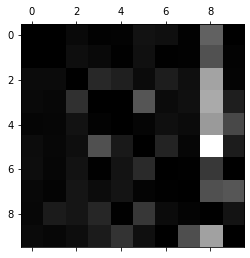

In [43]:
# Let's focus the plot on the errors
# First, let's divide each value in the confusion matrix by the number of images in the corresponding class,
#so we can compare error rates

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# Now let's fill the diagonal with zeros to keep only the errors, and let's plot the result
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## Multilabel Classification